In [1]:
# import sys
# !{sys.executable} -m pip install scikit-image

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import sys
from osgeo import gdal
import pickle
import matplotlib.pyplot as plt
from skimage import filters
from skimage import exposure

In [3]:
# file = "/mnt/poseidon/remotesensing/arctic/data/rasters/model_results_tiled/GRIDCELL_3100_graminoid.tif"
# opts = gdal.WarpOptions(format='GTiff', dstSRS='EPSG:4326')
# gdal.Warp(file, file, options=opts)

In [4]:
sys.version

'3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]'

In [5]:
xr.__version__

'2023.10.1'

In [6]:
# General Params
BASE = '/mnt/poseidon/remotesensing/arctic/data'
OUT_DIR = f'{BASE}/rasters/model_results_tiled_test06'
DATA_DIR = f'{BASE}/rasters'
CELL_LIST = list(range(2928,2929))
TEST_CELL_IDX = 0
TEST_CELL = CELL_LIST[TEST_CELL_IDX]
REF_RAST = f'{DATA_DIR}/s2_sr_tiled/ak_arctic_summer/B11/2019-06-01_to_2019-08-31/GRIDCELL_{TEST_CELL}.tif'
MODEL = f'{BASE}/training/Test_06/results/ModelTuning_FeatureImportance'
PFT_LIST = ['deciduous shrub', 'evergreen shrub', 'forb', 'graminoid', 'litter', 'non-vascular', 'lichen', 'bryophyte']
# Sensor-specific Params
S2_DIR = f'{DATA_DIR}/s2_sr_tiled/ak_arctic_summer/*/*'
S1_DIR = f'{DATA_DIR}/s1_grd_tiled'
DEM_DIR = f'{DATA_DIR}/acrtic_dem_tiled'

In [7]:
print('Number of gridcells to work on:', len(CELL_LIST))

Number of gridcells to work on: 1


## Definitions

In [8]:
def gridcell_rast_list(cell_num_list, directory):# read rasters with glob
    
    cell_list = []
    for cellnum in cell_num_list:
        cell_band_paths = sorted(glob.glob(f'{directory}/GRIDCELL_{cellnum}*'))
        cell_list.append(cell_band_paths)
    return cell_list

In [9]:
# function to stack sensor bands for one gridcell
# will need to loop through each sensor and gridcell
def stack_bands(sensor, cell_num,
                resample_bands, ref_rast, scale_factor=None):
    
    """
    Creates an xarray with each band recorded as a variable.
    sensor         : [str] sensor source of data (s2_sr, s1_grd, or dem)
    cell_num       : [int] gridcell number to analyze
    resample_bands : [list] bands that need to be rescaled to 20-meters
    ref_rast       : [xr.Dataset] raster used as the model resolution/crs
    scale_factor   : [float or int] number multiplied to rescale data
    Returns an xr.Dataset with x,y,band dimensions for one gridcell with 
    each band as a data variable that matches the resolution/scale of the
    reference raster.
    """

    raster_bands = []
    for band_path in cell_num:

        # get band name from file path
        if sensor == 's2_sr':
            b_name = band_path.split('/')[-3]
        elif sensor == 'dem':
            b_name = band_path.split('/')[-1]
            b_name = b_name.split('.')[0]
            b_name = b_name.split('_')[-1]
        elif sensor == 's1_grd':
            b_name = band_path.split('/')[-1]
            print(b_name)
            b_name = b_name.split('.')[0]
            b_name = b_name.split('_')[-1]
        else:
            print('Incorrect sensor choice. Try dem, s2_sr, or s1_grd.')
        print(f'Creating raster for {b_name}...')
        
        # open raster in xarray
        raster = rxr.open_rasterio(band_path)
        raster.name = b_name
        print(raster.sizes, raster.dims)
        # raster.plot()
        # plt.show()
        
        # resample and rescale if necessary
        print(f'Rescaling {b_name}...')
        raster = raster.rio.reproject_match(ref_rast)
        if scale_factor is not None:
            raster = raster * scale_factor
            
        # append to band list
        raster_bands.append(raster)

    merged = xr.merge(raster_bands)
    # drop pixel if any band is NA
    merged = merged.dropna(dim='band', how='any')
    return merged

In [10]:
# plot stacked raster and reference raster
def plot_rasters(raster, ref_raster, 
                 vmin, vmax, rvmin, rvmax):
    
    # plot to visualize if reference raster and adjusted
    # look visually correct
    fig, axes = plt.subplots(ncols=2, figsize=(12,4))
    raster.plot(ax=axes[0], vmin=vmin, vmax=vmax)
    ref_raster.plot(ax=axes[1], vmin=rvmin, vmax=rvmax)
    plt.draw()

In [11]:
def calc_veg_idx_s2(xrd):
    
    """
    Creates new data attributes for an s2_sr xr.Dataset with bands
    B2, B3, B4, B5, B6, B8, B8A, B11, and B12. Second step after 
    stack_bands. S2_sr data must be scaled from 0 to 1; can set
    scale factor in stack_bands function if necessary.
    xrd : [xr.Dataset] s2_sr xarray dataset
    Returns: xarray dataset with new vegetation indices
    """
    
    xrd = xrd.assign(ndwi1 = lambda x: (x.nir - x.swir1)/(x.nir + x.swir2))
    xrd = xrd.assign(ndwi2 = lambda x: (x.nir - x.swir2)/(x.nir + x.swir2))
    xrd = xrd.assign(msavi = lambda x: (2*x.nir + 1 -  ((2*x.nir + 1)**2 - 8*(x.nir - x.red))**0.5) * 0.5)
    xrd = xrd.assign(vari = lambda x: (x.green - x.red)/(x.green + x.red - x.blue))
    xrd = xrd.assign(rvi = lambda x: x.nir/x.red)
    xrd = xrd.assign(osavi = lambda x: 1.16 * (x.nir - x.red)/(x.nir + x.red + 0.16))
    xrd = xrd.assign(tgi = lambda x: (120 * (x.red - x.blue) - 190 * (x.red - x.green))*0.5)
    xrd = xrd.assign(gli = lambda x: (2 * x.green - x.red - x.blue)/(2 * x.green + x.red + x.blue))
    xrd = xrd.assign(ngrdi = lambda x: (x.green - x.red)/(x.green + x.red))
    xrd = xrd.assign(ci_g = lambda x: x.nir/x.green - 1)
    xrd = xrd.assign(gNDVI = lambda x: (x.nir - x.green)/(x.nir + x.green))
    xrd = xrd.assign(cvi = lambda x: (x.nir * x.red)/(x.green ** 2))
    xrd = xrd.assign(mtvi2 = lambda x: 1.5*(1.2*(x.nir - x.green) - 2.5*(x.red - x.green))/(((2*x.nir + 1)**2 - (6*x.nir - 5*(x.red**0.5))-0.5)**0.5))
    xrd = xrd.assign(brightness = lambda x: 0.3037 * x.blue +0.2793 * x.green +0.4743 * x.red +0.5585 * x.nir +0.5082 * x.swir1 + 0.1863 * x.swir2)
    xrd = xrd.assign(greenness = lambda x: 0.7243 * x.nir +0.0840 * x.swir1 - 0.2848 * x.blue - 0.2435 * x.green - 0.5436 * x.red - 0.1800 * x.swir2)
    xrd = xrd.assign(wetness = lambda x: 0.1509 * x.blue+0.1973* x.green+0.3279*x.red+0.3406*x.nir-0.7112*x.swir1 - 0.4572*x.swir2)
    xrd = xrd.assign(tcari = lambda x: 3 * ((x.redEdge1 - x.red)-0.2 * (x.redEdge1 - x.green)*(x.redEdge1/x.red)))
    xrd = xrd.assign(tci = lambda x: 1.2 * (x.redEdge1 - x.green)- 1.5 * (x.red - x.green)*((x.redEdge1/x.red)**0.5))
    xrd = xrd.assign(nari = lambda x: (1/x.green - 1/x.redEdge1)/(1/x.green + 1/x.redEdge1))

    return xrd

## Prepare Sentinel 2 Data

In [12]:
rast_list = gridcell_rast_list(CELL_LIST, S2_DIR)
print('Rasters to stack for gridcell:', rast_list[TEST_CELL_IDX])

Rasters to stack for gridcell: ['/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B11/2019-06-01_to_2019-08-31/GRIDCELL_2928.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B12/2019-06-01_to_2019-08-31/GRIDCELL_2928.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B2/2019-06-01_to_2019-08-31/GRIDCELL_2928.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B3/2019-06-01_to_2019-08-31/GRIDCELL_2928.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B4/2019-06-01_to_2019-08-31/GRIDCELL_2928.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B5/2019-06-01_to_2019-08-31/GRIDCELL_2928.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B6/2019-06-01_to_2019-08-31/GRIDCELL_2928.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s2_sr_tiled/ak_arctic_summer/B7/201

In [13]:
# create 20-m raster
scale_factor = 0.0001
reference_raster = rxr.open_rasterio(REF_RAST) * scale_factor
rescale_bands = ['B2', 'B3', 'B4', 'B8']
s2_stacked_raster = stack_bands('s2_sr', rast_list[TEST_CELL_IDX], 
                                rescale_bands, reference_raster, scale_factor)

Creating raster for B11...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B11...
Creating raster for B12...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B12...
Creating raster for B2...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B2...
Creating raster for B3...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B3...
Creating raster for B4...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B4...
Creating raster for B5...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B5...
Creating raster for B6...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B6...
Creating raster for B7...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y', 'x')
Rescaling B7...
Creating raster for B8...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling B8...
Creating raster for B8A...
Frozen({'band': 1, 'y': 900, 'x': 900}) ('band', 'y'

In [14]:
# rename bands to something legible
s2_stacked_raster = s2_stacked_raster.rename({'B2':'blue', 
                                              'B3':'green', 
                                              'B4':'red', 
                                              'B5':'redEdge1', 
                                              'B6':'redEdge2', 
                                              'B7':'redEdge3', 
                                              'B8A':'redEdge4', 
                                              'B8':'nir',
                                              'B11':'swir1',
                                              'B12':'swir2'})

In [15]:
# get ndwi for tianqi
rast = s2_stacked_raster.assign(ndwi = lambda x: (x.green - x.nir)/(x.green + x.nir))
rast = rast.assign(ndvi = lambda x: (x.nir - x.red)/(x.nir + x.red))
rast = rast.assign(wetness = lambda x: 0.1509 * x.blue+0.1973* x.green+0.3279*x.red+0.3406*x.nir-0.7112*x.swir1 - 0.4572*x.swir2)

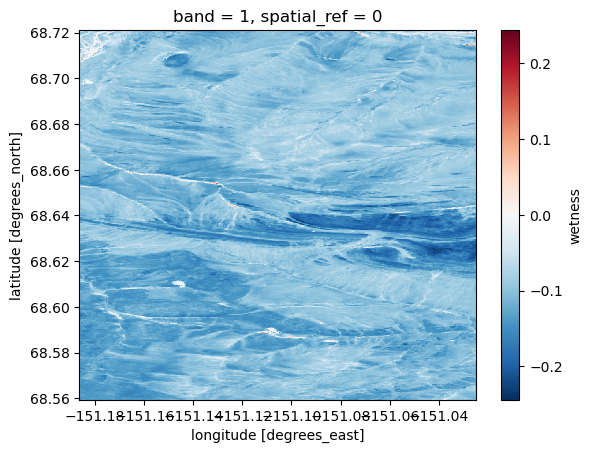

In [16]:
rast.wetness.plot()

In [17]:
def exp_height_equation(x, a, b):
    return a * np.exp(b * x)

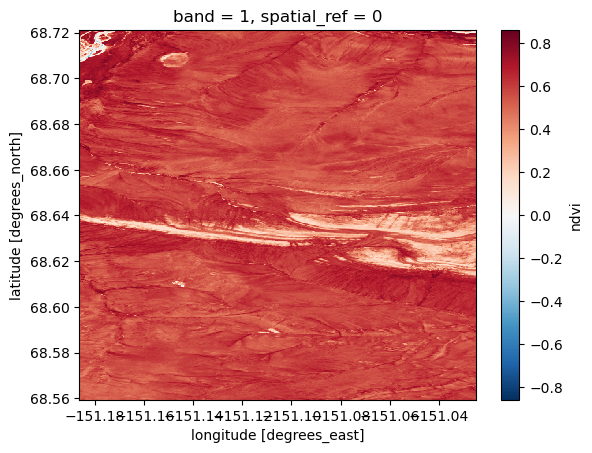

In [18]:
rast.ndvi.plot()

In [19]:
rast = rast.astype(np.float32)
masked_rast = rast.where((rast.ndvi > 0.3), np.nan)
masked_rast = masked_rast.assign(height_cm = lambda x: exp_height_equation(x.wetness, 276.53, 31.2436))

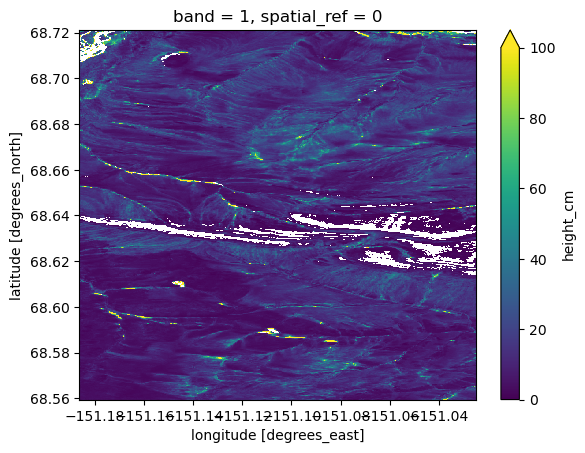

In [20]:
# plot
#
masked_rast.height_cm.plot(cmap='viridis', vmin=0, vmax=100)

Text(0.5, 1.0, 'Gridcell 2928 RGB')

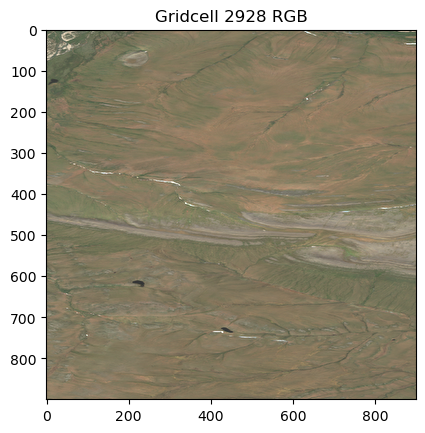

In [21]:
def adjust_brightness(image, factor):
    adjusted_image = np.clip(image * factor, 0, 1)  # Clip values to [0, 1]
    return adjusted_image
rgb = np.dstack((rast.isel(band=0).red.to_numpy(),
                 rast.isel(band=0).green.to_numpy(),
                 rast.isel(band=0).blue.to_numpy()))
b_rgb = adjust_brightness(rgb, 5)
plt.imshow(b_rgb, alpha=0.8, interpolation = 'sinc')
plt.title(f'Gridcell {TEST_CELL} RGB')

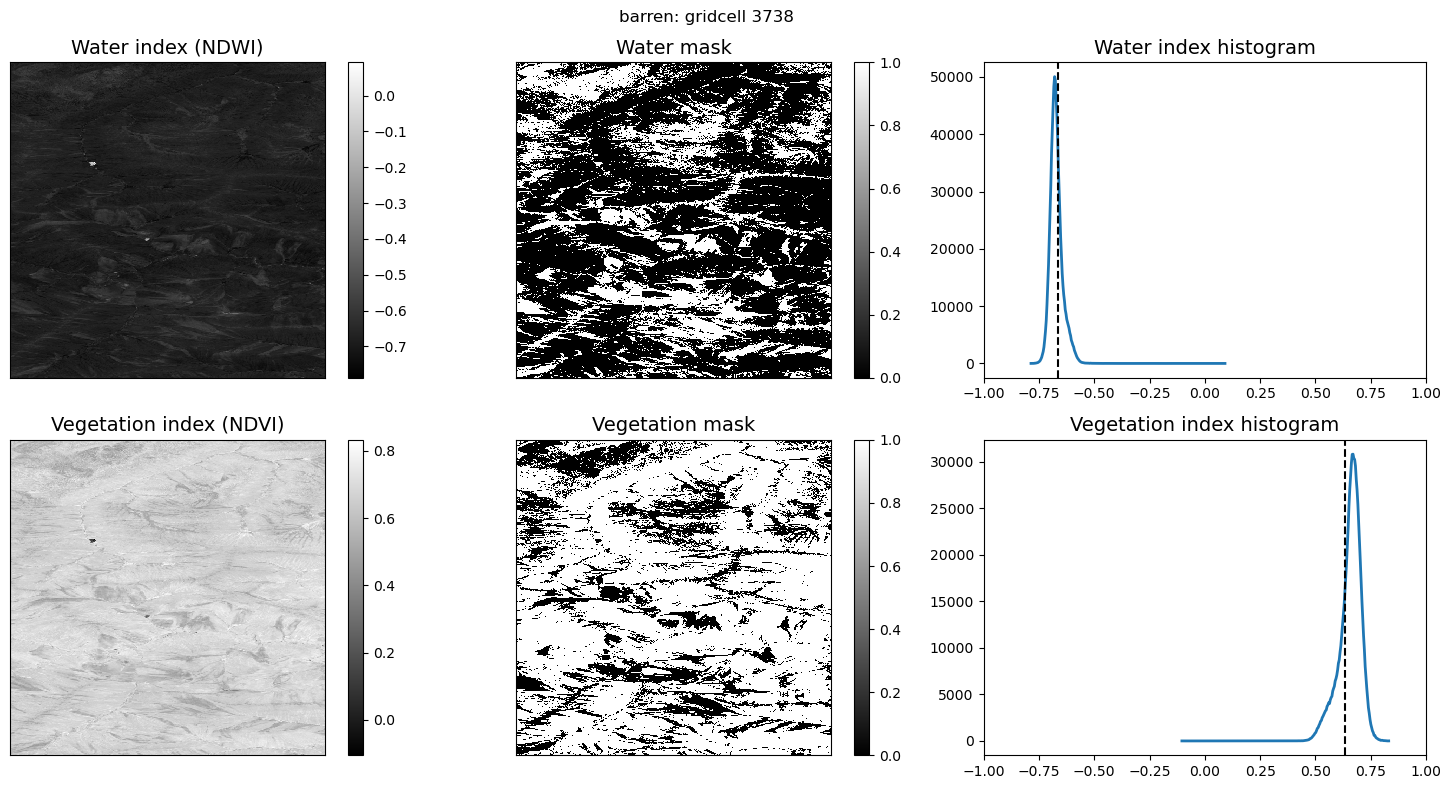

In [110]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure

f, axarr = plt.subplots(2,3, figsize=(15,8))
axlist = axarr.flatten()
f.suptitle(f'barren: gridcell {TEST_CELL}')

# # ndwi
ndwi_img = rast.isel(band=0).ndwi.to_numpy()
ndwi_val = filters.threshold_otsu(ndwi_img)
ndwi_hist, ndwi_bins_center = exposure.histogram(ndwi_img)
# maps
ndwi_base = axarr[0,0].imshow(ndwi_img, cmap='gray', interpolation='nearest')
axarr[0,0].set_title('Water index (NDWI)', fontsize=14)
ndwi_mask = axarr[0,1].imshow(ndwi_img > ndwi_val, cmap='gray', interpolation='nearest')
axarr[0,1].set_title('Water mask', fontsize=14)
# histogram
axarr[0,2].plot(ndwi_bins_center, ndwi_hist, lw=2)
axarr[0,2].axvline(ndwi_val, color='k', ls='--')
axarr[0,2].set_title('Water index histogram', fontsize=14)
axarr[0,2].set_xlim(-1,1)

# # ndvi
ndvi_img = rast.isel(band=0).ndvi.to_numpy()
ndvi_val = filters.threshold_otsu(ndvi_img)
ndvi_hist, ndvi_bins_center = exposure.histogram(ndvi_img)
# maps
ndvi_base = axarr[1,0].imshow(ndvi_img, cmap='gray', interpolation='nearest')
axarr[1,0].set_title('Vegetation index (NDVI)', fontsize=14)
ndvi_mask = axarr[1,1].imshow(ndvi_img > ndvi_val, cmap='gray', interpolation='nearest')
axarr[1,1].set_title('Vegetation mask', fontsize=14)
# histogram
axarr[1,2].plot(ndvi_bins_center, ndvi_hist, lw=2)
axarr[1,2].axvline(ndvi_val, color='k', ls='--')
axarr[1,2].set_title('Vegetation index histogram', fontsize=14)
axarr[1,2].set_xlim(-1,1)

for i in [0,1]:
    for j in [0,1]:
        axarr[i,j].tick_params(which='both', 
                               bottom=False, top=False, left=False, right=False,
                               labelbottom=False, labeltop=False, 
                               labelleft=False, labelright=False)
        
f.colorbar(ndvi_base, ax=axarr[1,0])
f.colorbar(ndvi_mask, ax=axarr[1,1])
f.colorbar(ndwi_base, ax=axarr[0,0])
f.colorbar(ndwi_mask, ax=axarr[0,1])
        
plt.tight_layout()
plt.show()

In [111]:
print(ndwi_val)
print(ndvi_val)

-0.66198266
0.633245


In [112]:
water_mask = rast.where(((rast.ndwi > 0) & (rast.ndvi < 0.3)), 0)
mask = water_mask.isel(band=0).ndwi

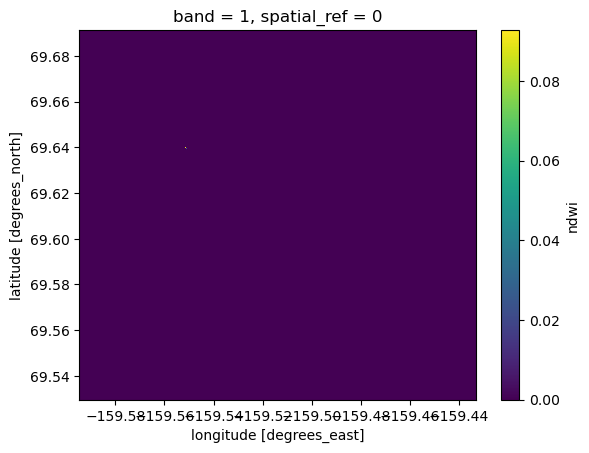

In [113]:
water_mask.ndwi.plot()

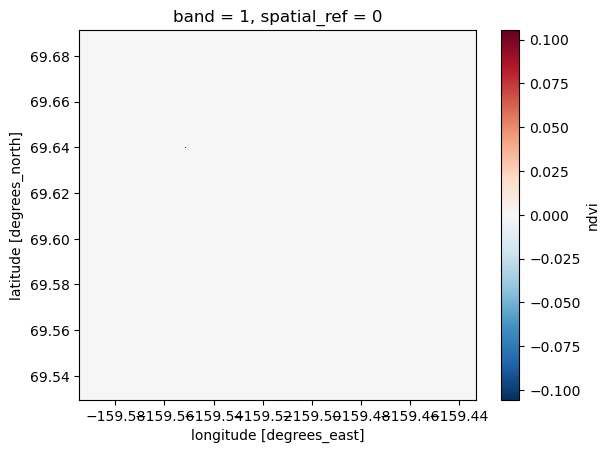

In [114]:
water_mask.ndvi.plot()

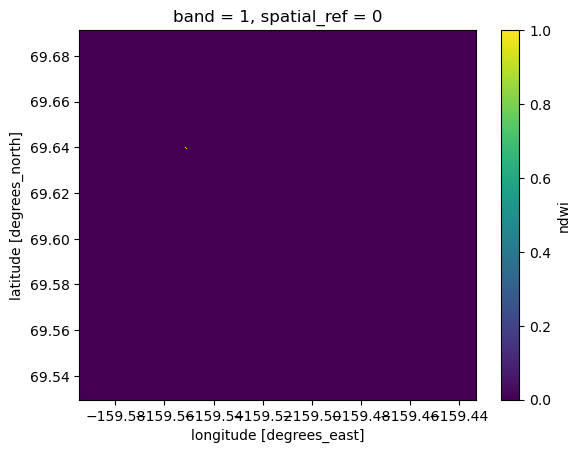

In [115]:
mask = mask.where((mask == 0), 1)
mask.plot()

In [116]:
mask

<xarray.DataArray 'ndwi' (y: 900, x: 900)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * x            (x) float64 -159.6 -159.6 -159.6 ... -159.4 -159.4 -159.4
  * y            (y) float64 69.69 69.69 69.69 69.69 ... 69.53 69.53 69.53 69.53

In [117]:
# calculate vegetation indices
stacked_raster_veg = calc_veg_idx_s2(s2_stacked_raster)
stacked_raster_veg

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -159.6 -159.6 -159.6 ... -159.4 -159.4 -159.4
  * y            (y) float64 69.69 69.69 69.69 69.69 ... 69.53 69.53 69.53 69.53
Data variables: (12/29)
    swir1        (band, y, x) float64 0.2275 0.2275 0.2266 ... 0.2288 0.2288
    swir2        (band, y, x) float64 0.1226 0.1226 0.1235 ... 0.1159 0.1159
    blue         (band, y, x) float64 0.0354 0.0354 0.0342 ... 0.02985 0.02985
    green        (band, y, x) float64 0.0623 0.0631 0.0617 ... 0.0571 0.0571
    red          (band, y, x) float64 0.0686 0.0667 0.0658 ... 0.05845 0.05845
    redEdge1     (band, y, x) float64 0.1252 0.1252 0.1257 ... 0.1233 0.1233
    ...           ...
    brightness   (band, y, x) float64 0.3597 0.3567 0.3553 ... 0.3569 0.3569
    greenness    (band, y, x) float64 0.1427 0.1406 0.1415 ... 0.1598 0.1598
    wetness      (band, y, x) float64 -0.07983 -0.08166 ... -0.07936 -0.07936
    tcari        (band, y, x) float64 0.1009 0.1056 0.1063 ... 0.1108 0.1108
    tci          (band, y, x) float64 0.06271 0.06712 0.0683 ... 0.0765 0.0765
    nari         (band, y, x) float64 0.3355 0.3298 0.3415 ... 0.367 0.367

## Prepare Sentinel 1 data

In [118]:
s1_rast_list = gridcell_rast_list(CELL_LIST, S1_DIR)
print('Rasters to stack for gridcell:', s1_rast_list[TEST_CELL_IDX])

Rasters to stack for gridcell: ['/mnt/poseidon/remotesensing/arctic/data/rasters/s1_grd_tiled/GRIDCELL_3738_VH.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/s1_grd_tiled/GRIDCELL_3738_VV.tif']


In [119]:
# create 20-m raster
scale_factor = 0.0001
reference_raster = rxr.open_rasterio(REF_RAST) * scale_factor
rescale_bands = ['VV', 'VH']
s1_stacked_raster = stack_bands('s1_grd', s1_rast_list[TEST_CELL_IDX], 
                                rescale_bands, reference_raster)

GRIDCELL_3738_VH.tif
Creating raster for VH...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling VH...
GRIDCELL_3738_VV.tif
Creating raster for VV...
Frozen({'band': 1, 'y': 1800, 'x': 1800}) ('band', 'y', 'x')
Rescaling VV...


In [120]:
s1_stacked_raster

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -159.6 -159.6 -159.6 ... -159.4 -159.4 -159.4
  * y            (y) float64 69.69 69.69 69.69 69.69 ... 69.53 69.53 69.53 69.53
Data variables:
    VH           (band, y, x) float32 0.0004072 0.0004033 ... 0.0006968
    VV           (band, y, x) float32 0.002085 0.001944 ... 0.003672 0.003897
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0.0

## Prepare Arctic DEM Data

In [121]:
dem_rast_list = gridcell_rast_list(CELL_LIST, DEM_DIR)
print('Rasters to stack for gridcell:', dem_rast_list[TEST_CELL_IDX])

Rasters to stack for gridcell: ['/mnt/poseidon/remotesensing/arctic/data/rasters/acrtic_dem_tiled/GRIDCELL_3738_dem.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/acrtic_dem_tiled/GRIDCELL_3738_dem_aspect.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/acrtic_dem_tiled/GRIDCELL_3738_dem_hillshade.tif', '/mnt/poseidon/remotesensing/arctic/data/rasters/acrtic_dem_tiled/GRIDCELL_3738_dem_slope.tif']


In [122]:
# create 20-m raster
scale_factor = 0.0001
reference_raster = rxr.open_rasterio(REF_RAST) * scale_factor
rescale_bands = ['aspect', 'dem', 'hillshade', 'slope']
dem_stacked_raster = stack_bands('dem', dem_rast_list[TEST_CELL_IDX], 
                                 rescale_bands, reference_raster)
dem_stacked_raster = dem_stacked_raster.rename({'dem':'elevation'})

Creating raster for dem...
Frozen({'band': 1, 'y': 925, 'x': 925}) ('band', 'y', 'x')
Rescaling dem...
Creating raster for aspect...
Frozen({'band': 1, 'y': 937, 'x': 937}) ('band', 'y', 'x')
Rescaling aspect...
Creating raster for hillshade...
Frozen({'band': 1, 'y': 937, 'x': 937}) ('band', 'y', 'x')
Rescaling hillshade...
Creating raster for slope...
Frozen({'band': 1, 'y': 937, 'x': 937}) ('band', 'y', 'x')
Rescaling slope...


In [123]:
rescale_bands2 = ['aspect', 'elevation', 'hillshade', 'slope']
dem_stacked_raster = dem_stacked_raster.where(dem_stacked_raster[rescale_bands2] != -9999., 0.)
dem_stacked_raster

<xarray.Dataset>
Dimensions:      (band: 1, y: 900, x: 900)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -159.6 -159.6 -159.6 ... -159.4 -159.4 -159.4
  * y            (y) float64 69.69 69.69 69.69 69.69 ... 69.53 69.53 69.53 69.53
Data variables:
    elevation    (band, y, x) float32 83.4 83.41 83.48 ... 84.24 84.24 84.82
    aspect       (band, y, x) float32 34.38 30.26 49.09 ... 95.16 95.16 99.32
    hillshade    (band, y, x) float64 180.0 180.0 180.0 ... 169.0 169.0 169.0
    slope        (band, y, x) float32 0.1288 0.1555 0.1111 ... 3.602 3.602 3.59
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

## Combine and Prep for Modelling

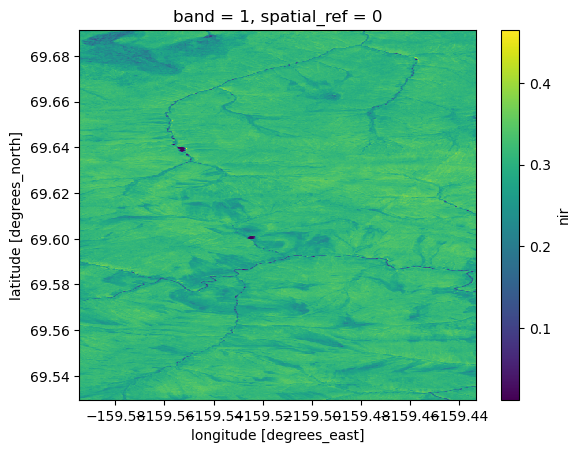

In [124]:
s2_stacked_raster.nir.plot()

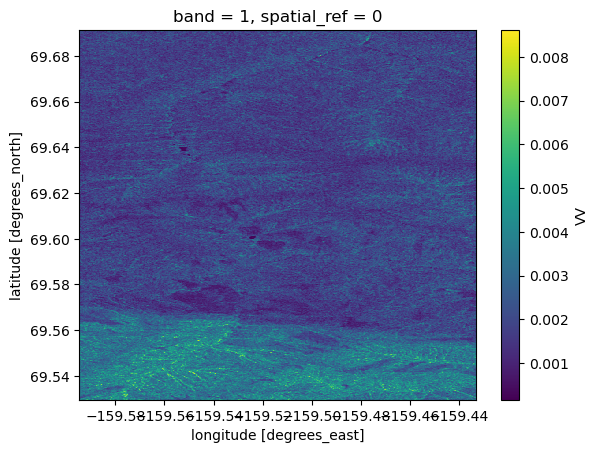

In [125]:
s1_stacked_raster.VV.plot()

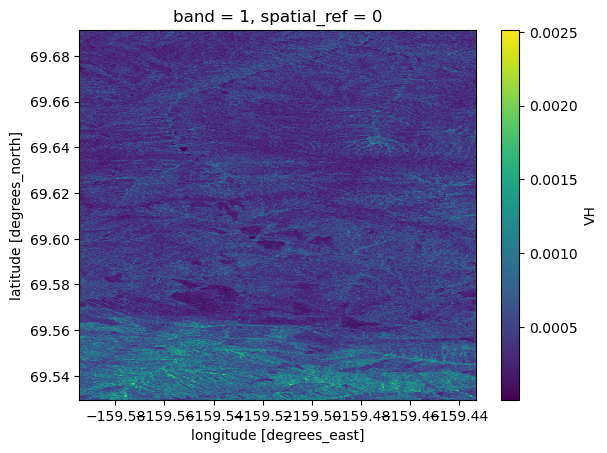

In [126]:
s1_stacked_raster.VH.plot()

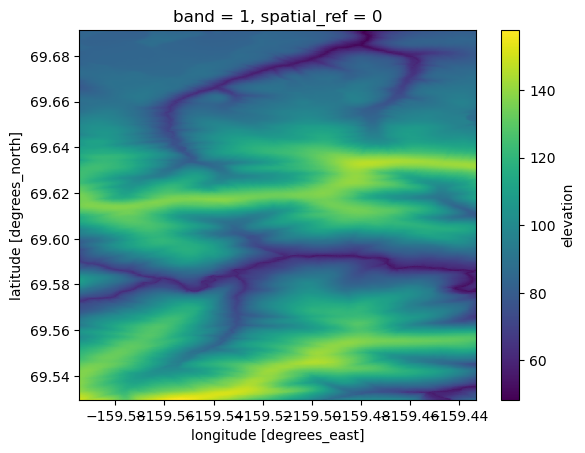

In [127]:
dem_stacked_raster.elevation.plot()

In [128]:
# make sure pandas df features are in the right order
stacked_raster = xr.merge([stacked_raster_veg, s1_stacked_raster, dem_stacked_raster])

In [129]:
stacked_raster

<xarray.Dataset>
Dimensions:      (band: 1, x: 900, y: 900)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -159.6 -159.6 -159.6 ... -159.4 -159.4 -159.4
  * y            (y) float64 69.69 69.69 69.69 69.69 ... 69.53 69.53 69.53 69.53
Data variables: (12/35)
    swir1        (band, y, x) float64 0.2275 0.2275 0.2266 ... 0.2288 0.2288
    swir2        (band, y, x) float64 0.1226 0.1226 0.1235 ... 0.1159 0.1159
    blue         (band, y, x) float64 0.0354 0.0354 0.0342 ... 0.02985 0.02985
    green        (band, y, x) float64 0.0623 0.0631 0.0617 ... 0.0571 0.0571
    red          (band, y, x) float64 0.0686 0.0667 0.0658 ... 0.05845 0.05845
    redEdge1     (band, y, x) float64 0.1252 0.1252 0.1257 ... 0.1233 0.1233
    ...           ...
    VH           (band, y, x) float32 0.0004072 0.0004033 ... 0.0006968
    VV           (band, y, x) float32 0.002085 0.001944 ... 0.003672 0.003897
    elevation    (band, y, x) float32 83.4 83.41 83.48 ... 84.24 84.24 84.82
    aspect       (band, y, x) float32 34.38 30.26 49.09 ... 95.16 95.16 99.32
    hillshade    (band, y, x) float64 180.0 180.0 180.0 ... 169.0 169.0 169.0
    slope        (band, y, x) float32 0.1288 0.1555 0.1111 ... 3.602 3.602 3.59

In [130]:
df = stacked_raster.to_dataframe()
coords = df.reset_index()
coords = coords[['x', 'y']]
coords

x          y
0      -159.594604  69.691210
1      -159.594604  69.691030
2      -159.594604  69.690851
3      -159.594604  69.690671
4      -159.594604  69.690491
...            ...        ...
809995 -159.433086  69.530411
809996 -159.433086  69.530232
809997 -159.433086  69.530052
809998 -159.433086  69.529872
809999 -159.433086  69.529693

[810000 rows x 2 columns]

In [131]:
df = df.droplevel([1, 2]).reset_index(drop=True)
df = df.iloc[:,1:]
df = df.astype("float32")
df

swir1    swir2     blue    green      red  redEdge1  redEdge2  \
0       0.22750  0.12260  0.03540  0.06230  0.06860   0.12520   0.22560   
1       0.22900  0.11800  0.03300  0.05560  0.05500   0.11640   0.22470   
2       0.22670  0.11810  0.02650  0.04920  0.05205   0.10985   0.22530   
3       0.22725  0.11900  0.02715  0.05085  0.05330   0.11180   0.23270   
4       0.23145  0.12060  0.02895  0.05465  0.05605   0.12205   0.24280   
...         ...      ...      ...      ...      ...       ...       ...   
809995  0.21365  0.10740  0.02255  0.05035  0.05435   0.11290   0.24185   
809996  0.22315  0.11615  0.02785  0.05640  0.05800   0.12385   0.24860   
809997  0.22730  0.11780  0.03020  0.05810  0.05970   0.12600   0.23770   
809998  0.22655  0.11405  0.02860  0.05640  0.05580   0.12305   0.23580   
809999  0.22880  0.11585  0.02985  0.05710  0.05845   0.12330   0.23755   

        redEdge3     nir  redEdge4  ...   wetness     tcari       tci  \
0        0.25480  0.2874   0.29240  ... -0.079835  0.100922  0.062713   
1        0.25590  0.2736   0.29280  ... -0.089642  0.106995  0.074269   
2        0.25720  0.2803   0.29165  ... -0.088981  0.096600  0.066570   
3        0.26285  0.2818   0.29585  ... -0.088439  0.098792  0.067818   
4        0.27340  0.2922   0.30460  ... -0.086692  0.109941  0.077781   
...          ...     ...       ...  ...       ...       ...       ...   
809995   0.27800  0.3133   0.30495  ... -0.063183  0.097690  0.066412   
809996   0.28280  0.3133   0.31165  ... -0.070750  0.111133  0.077433   
809997   0.27035  0.2996   0.29985  ... -0.077874  0.112916  0.077993   
809998   0.26850  0.3022   0.29790  ... -0.076596  0.113564  0.081316   
809999   0.27195  0.2977   0.30345  ... -0.079357  0.110761  0.076499   

            nari        VH        VV  elevation      aspect  hillshade  \
0       0.335467  0.000407  0.002085  83.398438   34.380344      180.0   
1       0.353488  0.000457  0.002032  83.414062  334.536652      181.0   
2       0.381327  0.000533  0.002915  83.343750   27.349876      180.0   
3       0.374731  0.000388  0.002631  83.375000   99.462326      180.0   
4       0.381437  0.000481  0.002646  83.437500   46.684685      180.0   
...          ...       ...       ...        ...         ...        ...   
809995  0.383155  0.001164  0.003700  79.218750   97.532005      166.0   
809996  0.374202  0.000914  0.003464  80.289062  105.954681      166.0   
809997  0.368821  0.000883  0.003298  81.789062  101.221283      167.0   
809998  0.371413  0.000801  0.003527  83.375000  100.876587      168.0   
809999  0.366962  0.000697  0.003897  84.820312   99.315712      169.0   

           slope  
0       0.128813  
1       0.260285  
2       0.365364  
3       0.272277  
4       0.269154  
...          ...  
809995  4.388068  
809996  4.732071  
809997  4.247640  
809998  4.055633  
809999  3.590119  

[810000 rows x 35 columns]

In [132]:
# find any bands that were divided by 0 and produced an inf value
bad_idx_list = df[df.values == np.inf].index.tolist()
df.drop(index=bad_idx_list, inplace=True)
coords.drop(index=bad_idx_list, inplace=True)

(810000,)
[0.35424433 0.42426767 0.5366985  ... 0.39769148 0.44057016 0.40874598]


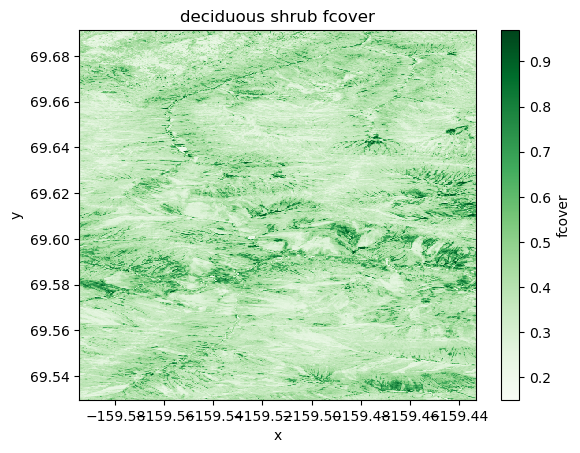

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/poseidon/remotesensing/arctic/data/training/Test_06/results/ModelTuning_FeatureImportance/tunedModel_evergreen shrub.pkl'

In [138]:
for PFT in PFT_LIST:
    
    # Load the pickled model from the file
    model_file_path = f'{MODEL}/tunedModel_{PFT}.pkl'
    demo_df = pd.read_csv(f'{MODEL}/FeatureDemo_non-vascular.csv', index_col=0)
    col_order = demo_df.columns.tolist()
    df = df[col_order]
    with open(model_file_path, 'rb') as model_file:
        model = pickle.load(model_file)

    # --- prediction directly used the model
    fCover = model.predict(df) # fCover is a 1 by n
    print(fCover.shape)
    print(fCover)
    
    # create dataframe
    results = coords.copy()
    results['fcover'] = fCover
    results['band'] = 1
    
    # create xarray and plot
    results_xr = xr.Dataset.from_dataframe(results.set_index(['band', 'y', 'x']))
    results_xr.fcover.plot(cmap='Greens')
    plt.title(f'{PFT} fcover')
    plt.show()
    
    # export tif
    # PFT = PFT.replace(' ', '_')
    # out_path=f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_{PFT}.tif"
    # results_xr.isel(band=0).rio.to_raster(out_path)
    
    # set CRS
    # opts = gdal.WarpOptions(format='GTiff', dstSRS='EPSG:4326')
    # gdal.Warp(out_path, out_path, options=opts)

In [36]:
# r = stacked_raster.red.values
# g = stacked_raster.green.values
# b = stacked_raster.blue.values
# r = r.reshape(900,900)
# g = g.reshape(900,900)
# b = b.reshape(900,900)

# def adjust_lightness(color, amount=0.5):
#     import matplotlib.colors as mc
#     import colorsys
#     try:
#         c = mc.cnames[color]
#     except:
#         c = color
#     c = colorsys.rgb_to_hls(*mc.to_rgb(c))
#     return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# rgb_uint8 = (np.dstack((r,g,b)) * 255.999 + 25) .astype(np.uint8)
# plt.imshow(rgb_uint8, vmin=25, vmax=10000)

In [37]:
# stacked_raster.red.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_red.tif")
# stacked_raster.green.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_green.tif")
# stacked_raster.blue.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_blue.tif")
# stacked_raster.nir.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_nir.tif")
# stacked_raster.VV.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_VV.tif")
# stacked_raster.VH.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_VH.tif")
# stacked_raster.elevation.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_elevation.tif")
# stacked_raster.slope.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_slope.tif")
# stacked_raster.aspect.isel(band=0).rio.to_raster(f"{OUT_DIR}/GRIDCELL_{CELL_LIST[TEST_CELL_IDX]}_aspect.tif")